In [3]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

# 2. 전처리
## 2-1 결측치 처리

In [7]:
from numpy.random import randint

wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

wine_m = wine.copy()
for col in ['Alcohol', 'Ash']:
    random_idx = randint(0, len(wine), 25)
    wine_m.loc[random_idx, col] = np.nan
print(wine_m.isna().sum())

Alcohol      23
Malicacid     0
Ash          23
Magnesium     0
Hue           0
dtype: int64


In [9]:
from sklearn.impute import SimpleImputer

# 결측치를 0으로 대치
wine_imp = wine_m.fillna(0)

# 결측치를 대표값으로 대치
# strategy = 'mean', 'median', or 'most_frequent'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

### 단순확률대치법
- 유사한 데이터셋에서 랜덤하게 샘플링한 값으로 대치
    - Hot-deck : 현재 진행중인 연구에서 비슷한 성향 데이터 중 랜덤 선택
    - Cold-deck : 외부 출처 혹은 비슷한 연구에서 대체할 데이터 가져오는 것

In [10]:
# Hot-Deck
# wine이 wine_m과 비슷한 성향이라고 가정하고 wine에서 랜덤하게 선택하여 wine_m 대치
wine_imp2 = wine_m.copy()

for feature in ['Alcohol', 'Ash']:
    missing_idx = wine_imp2.loc[wine_imp2[feature].isna()==True].index
    wine_imp2.loc[missing_idx, feature] = wine[feature].sample(len(missing_idx)).values

### 다른 변수들로 모델링하여 결측값 예측
- KNN imputer : 정확할 때가 많지만, 전체 데이터셋을 올려야해서 메모리가 많이 필요하고 이상치에 민감, 
- 기타 회귀 및 분류 알고리즘 이용 가능

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = pd.DataFrame(wine_imp3, columns=wine_m.columns)

### 보간법
- 시계열 데이터 결측치 대치 : linear, polynomial, spline
- 맨 앞의 결측치는 보간되지 않으므로 단순하게 다음값으로 채움

In [12]:
wine_imp4 = wine_m.interpolate(method='linear')

## 2-2. 이상치 처리
- 이상치 데이터 판정기준

1) ESD : mean-3\*std < data < mean+3\*std 

2) 기하평균 - 2.5 \* std < data < 기하평균 + 2.5 \* std

3) Q1 - 1.5\* IQR < data < Q3 + 1.5\* IQR

4) DBSCAN 통해 -1로 분류되는 값

- 이상치 처리방법 : 절단, 조정, 클리핑

### 절단
- 절단 후 새로운 이상치 생길 수 있으나 이는 분석가가 상황에 맞게 설정 필요

In [14]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + IQR * 1.5
down = wine['Malicacid'].quantile(0.25) - IQR * 1.5

out_id = wine.loc[(wine['Malicacid']>=top) | (wine['Malicacid']<=down)].index

# 절단
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

### 조정
- 이상치를 앞서 정해진 이상치의 상한과 하한선으로 보정

In [15]:
prep_df2 = wine[['Malicacid']].clip(down, top)

### 클리핑
- 이상치 상, 하한을 특정값으로 지정하여, 벗어나는 값을 조정
- 이상치 경계값에 대한 확실한 정보를 가지고 있거나, 데이터를 특정 경계값으로 제한하고 싶을 때

In [16]:
prep_df3 = wine[['Malicacid']].clip(1,5)

## 2-3 클래스 불균형 처리
- 오버샘플링 & 언더샘플링

In [17]:
from sklearn.datasets import load_breast_cancer
from collections import Counter

data = load_breast_cancer()
df = pd.DataFrame(np.c_[data['data'], data['target']], 
                  columns = list(data.feature_names) + ['target'])

df = df.filter(['mean radius', 'mean texture', 'mean area', 'target'])
print("3 front rows: \n", df.head(3), "\n")
print("original data class distribution:", Counter(df['target']))


df1 = df.loc[df['target']==0].sample(50)
df2 = df.loc[df['target']==1].sample(250)
imb_df = pd.concat([df1, df2]).reset_index(drop=True)
print("imbalanced data class distribution: ", Counter(imb_df['target']))

features = imb_df.drop('target', axis=1)
target = imb_df['target']

3 front rows: 
    mean radius  mean texture  mean area  target
0        17.99         10.38     1001.0     0.0
1        20.57         17.77     1326.0     0.0
2        19.69         21.25     1203.0     0.0 

original data class distribution: Counter({1.0: 357, 0.0: 212})
imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})


### 랜덤 오버샘플링
- 기존에 존재하는 소수의 클래스를 단순복제
- 분포의 편화는 없으나 소수 클래스인 데이터가 많아지면서 해당 클래스에 대한 가중치가 높아지게 된다. 한편 단순히 동일 데이터의 증가이므로 과적할 될 수도 있다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


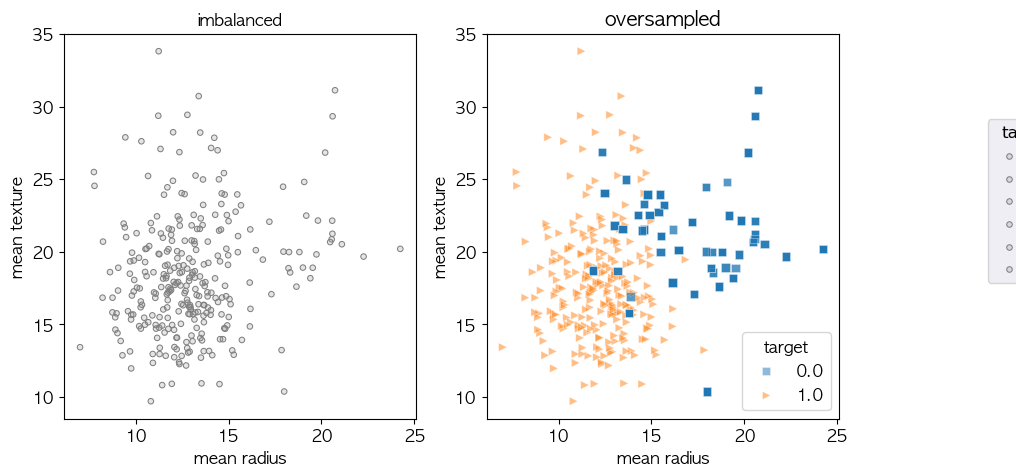

In [37]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df1 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
so.Plot(data=imb_df, x='mean radius', y='mean texture', color='target').add(so.Dots(color="0.5"))\
 .label(title='imbalanced').on(ax[0]).plot()

# ax[0].set_title("imbalanced")
# sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
#                ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df1,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);

plt.show()

### SMOTE (synthetic minority oversampling technique)
- 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터 생성
    - 임의의 소수 클래스 x를 잡고 가장 가까운 k개의 이웃을 찾은 다음, k개의 이웃과 x사이에 임의의 새로운 데이터 x' 생성

In [22]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df2 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


In [ ]:
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, axㅁㅁㅁ, title in zip([wine[['Malicacid']], prep_df], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()